# ДЗ 1. Отчёт о трансформерной модели

## Longformer: The Long-Document Transformer

[Оригинальная статья](https://arxiv.org/abs/2004.05150)

### Введение

Longformer - трансформерная модель, основной мотивацией реализации которой, по словам авторов, стало то, что базовая архитектура трансформеров "не может" работать с длинными последовательностями из-за квадратичной сложности операции self-attention - именно для борьбы с этим недостатком было предложено решение в данной статье. Таким образом, Longformer - модель на основе трансформерной архитектуры, которая "умеет" работать с длинными последовательностями (документами), при этом квадратично не увеличивая вычислительную сложность.

### Архитектура модели и ключевые особенности

В статье основной акцент делается на том, что "стандартные" архитектуры трансформеров не умеют работать с длинными последовательностями, что обычно приводит к тому, что последовательность обрезается до некоторого максимума (например, 512 токенов), что неизбежно приводит к потере информации, которая может быть важной для решения той или иной задачи. Авторы предлагают заменить механизм внимания таким образом, чтобы сложность его вычисления перестала быть квадратичной и стала линейной - это позволит учитывать __всю__ последовательность и тем самым сохранять весь контекст, что должно позволить решать различные задачи. 

Авторы также отмечают, что алгоритм Longformer self-attention может выступать как drop-in замена для стандартного self-attention в предобученных моделях.

Итак, для решения обозначенной проблемы было предложено ввести 2 механизма self-attention:
- локальный, который представляет информацию в некотором окне;
- глобальный, который представляет информацию о всей последовательности целиком.

Исследования, по словам автором, показали, что оба представленных механизмы по-своему важны.

К основным улучшениям, о которых говорится к статье, авторы пришли путем подмены self-attention на Longformer self-attention в предобученной модели RoBERTa. Эксперименты, проведенные на задачах с длинными документами, показали, что Longformer лучше RoBERTa по качеству.

#### Longformer self-attention

Для описания авторы вводят несколько вариантов attention, демонстрация которых приводится на изображении.

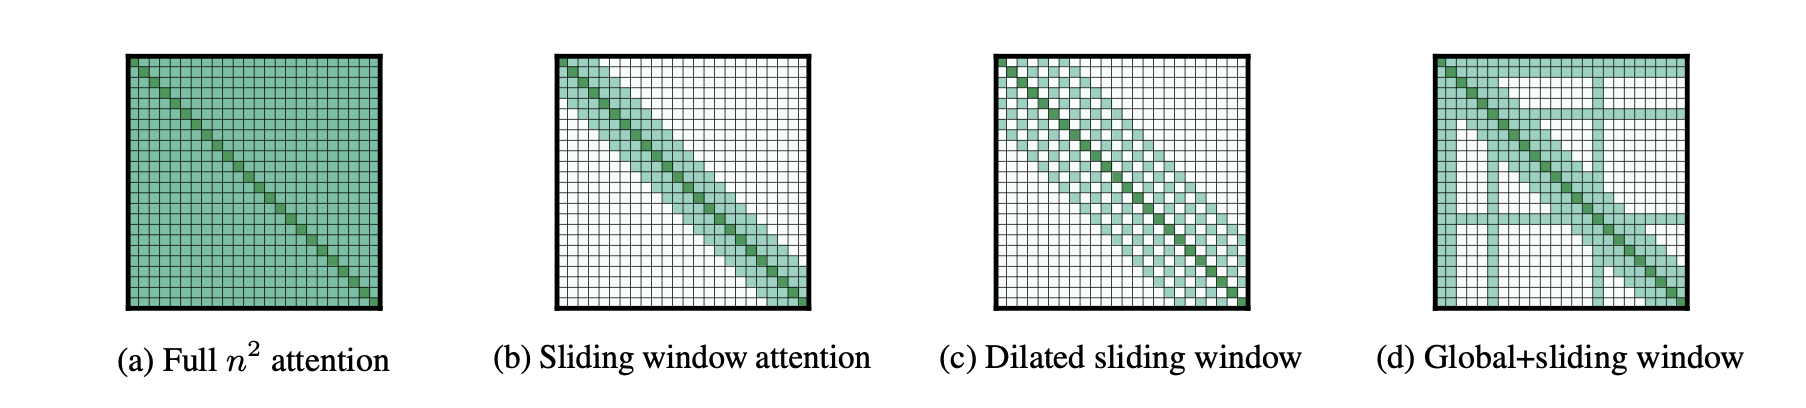

##### Sliding window

В этом варианте внимания расчёт происходит в фиксированном окне размера `w`, соответственно от каждого токена берется $\frac{w}{2}$ токенов "до" и столько же "после", пример можно видеть на картинке (b). При этом если сделать несколько подобных attention слоев последовательно, то можно увеличить "receptive field". Также отмечается, что сложность при таком подходе равняется `O(n × w)` и с учётом фиксированного окна, рост будет линейным.

##### Dilated Sliding Window

Данный вид окна/self-attention вводится в том числе для того, чтобы увеличить "receptive field", не увеличивая при этом вычисления (на прошлом шаге увеличение "receptive field" предлагалось за счет нескольких последовательных self-attention слоев). Суть данного решение кроется в слове `dilated`: в описанный на прошлом шаге вариант добавляется параметр `d`, который отвечает за шаг (или же размер пропуска), с которым берутся токены относительно `query`. Наглядный пример можно увидеть на рисунке (c). Таким образом, не увеличивая сложность относительно прошлого шага, получается учитывать более широкий контекст.

##### Global Attention

По словам авторов, несмотря на то, что прошлые варианты в каком-то виде могут учесть широкий контекст (в первую очередь за счёт большого "receptive field"), они всё ещё не способны хорошо "понимать" глобальный контекст. Для этого вводится `global attention` - в нём для расчёта внимания выбираются только важные для конкретной задачи токены (например, CLS) и затем внимание считается только для них. Подчеркивается, что глобальное внимание вводится симметричным, то есть выбранные токены смотрят на все токены в последовательности и наоборот - все токены в последовательности смотрят на выбранные токены. Из-за того, что таких "выбранных" токенов `<< n`, это достаточно "легко" для вычислений.

#### Реализация

Далее авторы сравнивают различные варианты реализации описанных модификаций self-attention. Результаты сравнения показываются на изображении:

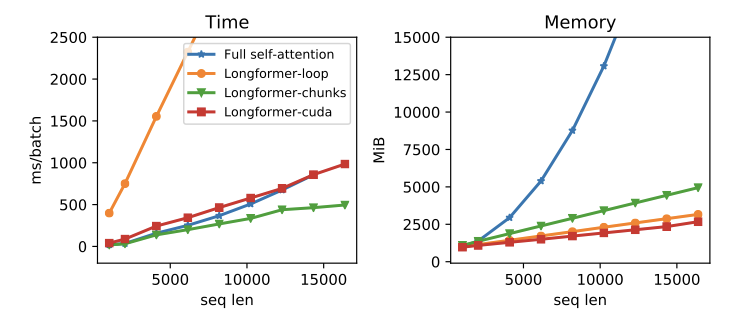

По итогам получается, что лучше всего себя проявляется chunks реализация.

#### Итог

Итого, были рассмотрены все ключевые моменты, которые были представлены в статье Longformer: The Long-Document Transformer, а именно модификация механизма self-attention для возможности эффектиктивного учёта длинных контекстов. В остальном же, если говорить про "строительные блоки", модель использует для основания RoBERTa, но по факту данные модификация может бытб применена и к другой модели, поскольку ключевой особенностью является именно замена self-attention блока.

### Гипотеза по замене Positional Encoding блока

В финальном варианте, которые использовали авторы статьи используется следующее: 
1. берутся обученные энкодинги из RoBERTa (используется обученное абсолютное кодирование позиций), максимальная позиция в которых равна 512;
2. блоки позиционных энкодингов заменяются на новые с максимальной позицией равной 4096;
3. новые блоки инициализируются путём копирования N раз энкодингов из п1.

Авторы пишут, что такая инициализация, позволяет быстро "дообучить" эмбединги. 

Глобально, мне кажется, что идея с подобной инициализацией достаточно хорошая и одним из вариантов может быть следующее: берем некоторую другую модель (не RoBERTa) с обучаемыми эмбедингами и повторяем логику с инициализацией. Но поскольку в задании хотим попробовать что-то другое, то я решил попробовать XPos (https://arxiv.org/abs/2212.10554v1), который является модификацией RoPE с потенциальной возможностью учитывать больший контекст. Алгоритм:

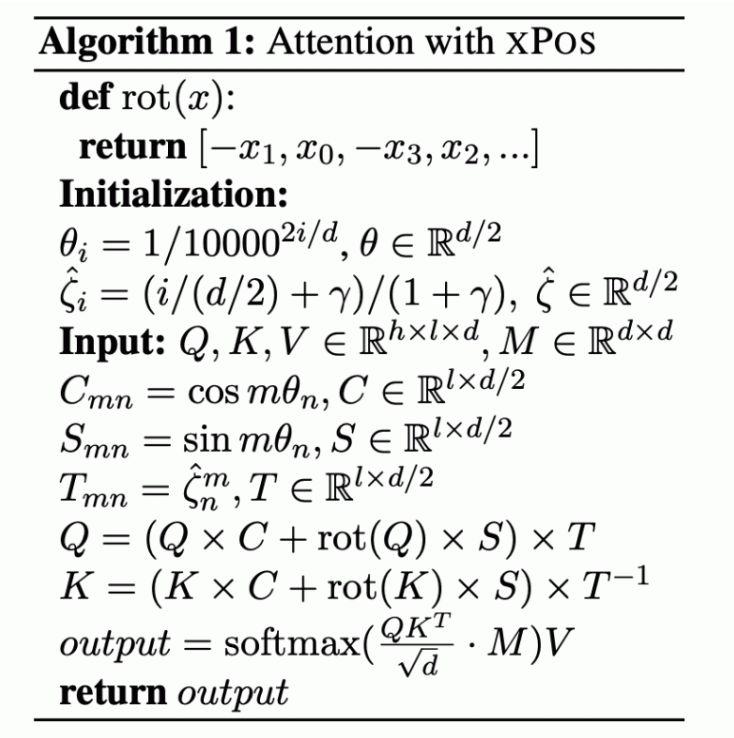

### Sanity-check

In [1]:
# https://github.com/lucidrains/rotary-embedding-torch
! pip install rotary-embedding-torch

In [2]:
import torch
from transformers import (
    LongformerModel, 
    LongformerTokenizer,
)
from rotary_embedding_torch import RotaryEmbedding

shakespeare_text = """William Shakespeare (bapt. 26 April 1564 – 23 April 1616)[a] was an English playwright, poet, and actor, widely regarded as the greatest writer in the English language and the world's greatest dramatist.[2][3][4] He is often called England's national poet and the "Bard of Avon" (or simply "the Bard").[5][b] His extant works, including collaborations, consist of some 39 plays,[c] 154 sonnets, two long narrative poems, and a few other verses, some of uncertain authorship. His plays have been translated into every major living language and are performed more often than those of any other playwright.[7] They also continue to be studied and reinterpreted."""


In [3]:
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

/Users/vyacheslav.kostrov/my/hse-mlds/subjects/deep-learning-1/.conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
model.embeddings.position_embeddings

Embedding(4098, 768, padding_idx=1)

In [5]:
from types import MethodType

def check_call(foo):
    """Проверка, что новый эмбединг действительно вызывался."""
    def wrapper(self, *args, **kwargs):
        print(f"called {self}")
        return foo(*args, **kwargs)
    
    return wrapper


new_positional_embedding = RotaryEmbedding(dim=768, use_xpos=True, cache_max_seq_len=4098)
new_positional_embedding.forward = MethodType(check_call(new_positional_embedding.forward), new_positional_embedding)
model.embeddings.position_embeddings = new_positional_embedding

In [6]:
def get_model_outputs(text, tokenizer, model, max_length=4096):
  input_ids = torch.tensor(tokenizer.encode(text)[0:max_length]).unsqueeze(0)
  attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device)

  outputs = model(input_ids, attention_mask=attention_mask)
  return outputs

shakespeare_embedding = get_model_outputs(shakespeare_text, tokenizer, model)

Input ids are automatically padded to be a multiple of `config.attention_window`: 512


called RotaryEmbedding()


In [7]:
shakespeare_embedding

LongformerBaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.0521,  0.0742, -0.0052,  ..., -0.0786, -0.0250, -0.0720],
         [-0.0504,  0.0716, -0.0056,  ..., -0.0759, -0.0214, -0.0739],
         [-0.0458,  0.0631, -0.0091,  ..., -0.0636, -0.0128, -0.0808],
         ...,
         [-0.0490,  0.0690, -0.0073,  ..., -0.0728, -0.0185, -0.0766],
         [-0.0490,  0.0690, -0.0073,  ..., -0.0728, -0.0185, -0.0766],
         [-0.0490,  0.0690, -0.0073,  ..., -0.0728, -0.0185, -0.0766]]],
       grad_fn=<SliceBackward0>), pooler_output=tensor([[ 1.6521e-01, -2.8896e-01,  1.1183e-01,  5.1758e-02,  3.3732e-01,
         -2.3209e-01, -4.7585e-01, -4.5000e-01, -1.0802e-01, -2.8310e-01,
         -3.9423e-01, -1.6905e-01,  2.1653e-01, -3.3740e-01,  1.4901e-01,
         -1.5463e-01, -4.2475e-01, -1.1551e-01, -1.0234e-01, -2.5281e-02,
         -8.7620e-03, -4.7101e-02, -2.1812e-01,  2.5249e-02, -4.4516e-01,
          8.5082e-03, -1.9084e-01, -2.8124e-01,  2.2996e-01,  1.6126e-01,
         -8